<a href="https://colab.research.google.com/github/OkoksNeDam/geoinformation-data-forecasting/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting data from KEV station with LSTM

## Import libraries

In [1]:
import torch
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random
import os
import copy

## Seed everything

In [102]:
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    tf.random.set_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_everything(SEED)
g = torch.Generator()
g.manual_seed(SEED)

## Install data

In [3]:
import gdown
# Main data.
data_url         = 'https://drive.google.com/drive/folders/1HH70Q8NDpA3kPflrldGSdYRUs5tWxclI?usp=sharing'

links = [data_url]

# Downloading data.
for url in links:
    gdown.download_folder(url, quiet=True)

In [4]:
df_train, df_val, df_test = pd.read_csv('/content/data/train/train.csv'), pd.read_csv('/content/data/val/val.csv'), pd.read_csv('/content/data/test/test.csv')

In [5]:
df_train.head()

,ds,y
0,2003-01-01 01:00:00,1824.7
1,2003-01-01 02:00:00,1823.6
2,2003-01-01 03:00:00,1814.7
3,2003-01-01 04:00:00,1816.8
4,2003-01-01 05:00:00,1816.4


## Some functions

Define method for fill missing values

In [6]:
def fill_missing_values(dataframe, method):
    dataframe = dataframe.copy(deep=True)
    # fill with mean.
    if method == 'mean':
        return dataframe.fillna(dataframe.mean(numeric_only=True).round(1))
    # fill with median.
    if method == 'median':
        return dataframe.fillna(dataframe.median(numeric_only=True).round(1))
    # if there are nan left, fill with bfill.
    if method == 'ffill':
        return dataframe.fillna(method=method).fillna(method='bfill')
    # filling occurs with next values.
    # if there are nan left, fill with ffill.
    if method == 'bfill':
        return dataframe.fillna(method=method).fillna(method='ffill')
    # fill with backward interpolation.
    # if there are nan left, fill with forward.
    if method == 'interpolate_backward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='backward')
                                              .interpolate(method ='linear', limit_direction ='forward') if col.name != "ds" else col)
    # fill with knn method.
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=15)
        dataframe = dataframe.apply(lambda col: imputer.fit_transform(col.to_numpy().reshape(-1, 1)).T[0] if col.name != "ds" else col)
        return dataframe

    return dataframe

Method to split data into sequences

In [7]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

Method for calculating smape metric

In [8]:
def calc_smape(actual, predicted) -> float:

    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)

    return np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2) ) * 100

Visualization of metrics while training

In [9]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_metrics(train_losses, val_mape, val_smape):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train loss')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(val_mape) + 1), val_mape, label='val mape')
    axs[1].plot(range(1, len(val_smape) + 1), val_smape, label='val smape')
    axs[1].set_ylabel('mape/smape')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [10]:
def find_best_metric_by_filling_method(train, val, method):
    df_train_filled = fill_missing_values(train, method=method)
    df_val_filled = fill_missing_values(val, method=method)

    scaler = StandardScaler()
    df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
    df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]

    df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
    df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')

    df_train_filled.drop(columns=['ds'], inplace=True)
    df_val_filled.drop(columns=['ds'], inplace=True)

    WINDOW_SIZE = 5

    X_train, y_train = df_to_X_y(df_train_filled, WINDOW_SIZE)
    X_val, y_val = df_to_X_y(df_val_filled, WINDOW_SIZE)

    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=[RootMeanSquaredError()])
    model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

    return min(model_history.history['val_loss'])

## Find best method for filling missing values:

### 1. Fill NaN values with <i><b>mean</b></i> method.

In [ ]:
mean_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'mean')

Epoch 1/20
4553/4553 [==============================] - 31s 6ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 2/20
4553/4553 [==============================] - 30s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/20
4553/4553 [==============================] - 30s 7ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 4/20
4553/4553 [==============================] - 38s 8ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/20
4553/4553 [==============================] - 32s 7ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/20
4553/4553 [==============================] - 31s 7ms/step - loss: 0.0144 - root_mean_squared_error: 0.1199 - val_l

In [ ]:
print(f'Best val_loss for mean: ', mean_best_val_loss)

Best val_loss for mean:  0.012667709030210972


### 2. Fill NaN values with <i><b>median</b></i> method.

In [ ]:
median_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'median')

Epoch 1/20
4553/4553 [==============================] - 33s 7ms/step - loss: 0.0301 - root_mean_squared_error: 0.1735 - val_loss: 0.0477 - val_root_mean_squared_error: 0.2185
Epoch 2/20
4553/4553 [==============================] - 31s 7ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1896
Epoch 3/20
4553/4553 [==============================] - 31s 7ms/step - loss: 0.0161 - root_mean_squared_error: 0.1268 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1840
Epoch 4/20
4553/4553 [==============================] - 33s 7ms/step - loss: 0.0153 - root_mean_squared_error: 0.1238 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1908
Epoch 5/20
4553/4553 [==============================] - 31s 7ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0343 - val_root_mean_squared_error: 0.1852
Epoch 6/20
4553/4553 [==============================] - 33s 7ms/step - loss: 0.0146 - root_mean_squared_error: 0.1206 - val_l

In [ ]:
print(f'Best val_loss for median: ', median_best_val_loss)

Best val_loss for median:  0.03105010837316513


### 3. Fill NaN values with <i><b>ffill</b></i> method.

In [ ]:
ffill_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'ffill')

Epoch 1/20
4553/4553 [==============================] - 43s 9ms/step - loss: 0.0261 - root_mean_squared_error: 0.1617 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2525
Epoch 2/20
4553/4553 [==============================] - 34s 8ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1977
Epoch 3/20
4553/4553 [==============================] - 50s 11ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1776
Epoch 4/20
4553/4553 [==============================] - 27s 6ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1734
Epoch 5/20
4553/4553 [==============================] - 27s 6ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1630
Epoch 6/20
4553/4553 [==============================] - 43s 10ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val

In [ ]:
print(f'Best val_loss for ffill: ', ffill_best_val_loss)

Best val_loss for ffill:  0.02440565824508667


### 4. Fill NaN values with <i><b>bfill</b></i> method.

In [ ]:
bfill_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'bfill')

Epoch 1/20
4553/4553 [==============================] - 27s 6ms/step - loss: 0.0271 - root_mean_squared_error: 0.1647 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2260
Epoch 2/20
4553/4553 [==============================] - 26s 6ms/step - loss: 0.0148 - root_mean_squared_error: 0.1216 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1805
Epoch 3/20
4553/4553 [==============================] - 29s 6ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1599
Epoch 4/20
4553/4553 [==============================] - 34s 7ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1426
Epoch 5/20
4553/4553 [==============================] - 27s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1312
Epoch 6/20
4553/4553 [==============================] - 31s 7ms/step - loss: 0.0124 - root_mean_squared_error: 0.1115 - val_l

In [ ]:
print(f'Best val_loss for bfill: ', bfill_best_val_loss)

Best val_loss for bfill:  0.015073384158313274


### 5. Fill NaN values with <i><b>interpolate_backward</b></i> method.

In [ ]:
interpolate_backward_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'interpolate_backward')

Epoch 1/20
4553/4553 [==============================] - 29s 6ms/step - loss: 0.0218 - root_mean_squared_error: 0.1478 - val_loss: 0.0430 - val_root_mean_squared_error: 0.2073
Epoch 2/20
4553/4553 [==============================] - 26s 6ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1796
Epoch 3/20
4553/4553 [==============================] - 25s 6ms/step - loss: 0.0135 - root_mean_squared_error: 0.1160 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 4/20
4553/4553 [==============================] - 24s 5ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1611
Epoch 5/20
4553/4553 [==============================] - 24s 5ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1526
Epoch 6/20
4553/4553 [==============================] - 27s 6ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_l

In [ ]:
print(f'Best val_loss for interpolate_backward: ', interpolate_backward_best_val_loss)

Best val_loss for interpolate_backward:  0.023031016811728477


### 6. Fill NaN values with <i><b>knn</b></i> method.

In [ ]:
knn_best_val_loss = find_best_metric_by_filling_method(df_train, df_val, 'knn')

Epoch 1/20
4553/4553 [==============================] - 29s 6ms/step - loss: 0.0294 - root_mean_squared_error: 0.1715 - val_loss: 0.0611 - val_root_mean_squared_error: 0.2471
Epoch 2/20
4553/4553 [==============================] - 25s 5ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 3/20
4553/4553 [==============================] - 26s 6ms/step - loss: 0.0158 - root_mean_squared_error: 0.1256 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1592
Epoch 4/20
4553/4553 [==============================] - 27s 6ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1492
Epoch 5/20
4553/4553 [==============================] - 25s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1419
Epoch 6/20
4553/4553 [==============================] - 25s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_l

In [ ]:
print(f'Best val_loss for knn: ', knn_best_val_loss)

Best val_loss for knn:  0.01810467429459095


# Hyperparameter tuning

## Find best number of lags

In [61]:
FILLING_NAN_METHOD = 'mean'

df_train_filled = fill_missing_values(df_train, method=FILLING_NAN_METHOD)
df_val_filled = fill_missing_values(df_val, method=FILLING_NAN_METHOD)

scaler = StandardScaler()
df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]

df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')

df_train_filled.drop(columns=['ds'], inplace=True)
df_val_filled.drop(columns=['ds'], inplace=True)

### 1. Number of lags = <i><b>5</b></i>.

In [63]:
N_LAGS = 5

In [64]:
X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(InputLayer((N_LAGS, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
4553/4553 [==============================] - 27s 5ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 2/30
4553/4553 [==============================] - 25s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/30
4553/4553 [==============================] - 24s 5ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 4/30
4553/4553 [==============================] - 24s 5ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/30
4553/4553 [==============================] - 24s 5ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/30
4553/4553 [==============================] - 26s 6ms/step - loss: 0.0144 - root_mean_squared_error: 0.1199 - val_l

In [65]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

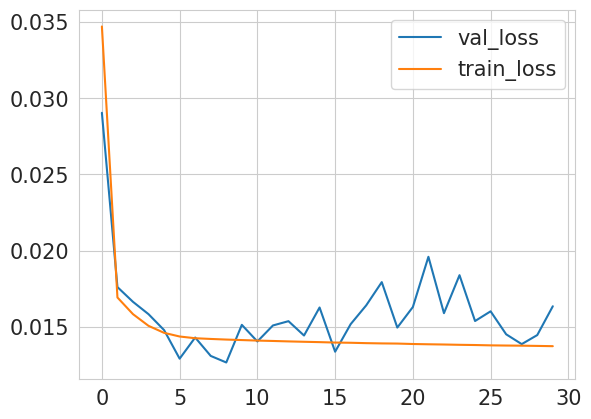

In [66]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [68]:
print(f'Best val_loss for lags=5: ', round(min(val_losses), 5))

Best val_loss for lags=5:  0.01267


### 2. Number of lags = <i><b>10</b></i>.

In [72]:
N_LAGS = 10

In [73]:
X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(InputLayer((N_LAGS, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
4553/4553 [==============================] - 39s 8ms/step - loss: 0.0346 - root_mean_squared_error: 0.1861 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1446
Epoch 2/30
4553/4553 [==============================] - 35s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 3/30
4553/4553 [==============================] - 36s 8ms/step - loss: 0.0157 - root_mean_squared_error: 0.1255 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1231
Epoch 4/30
4553/4553 [==============================] - 37s 8ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1274
Epoch 5/30
4553/4553 [==============================] - 37s 8ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1303
Epoch 6/30
4553/4553 [==============================] - 37s 8ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_l

In [74]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

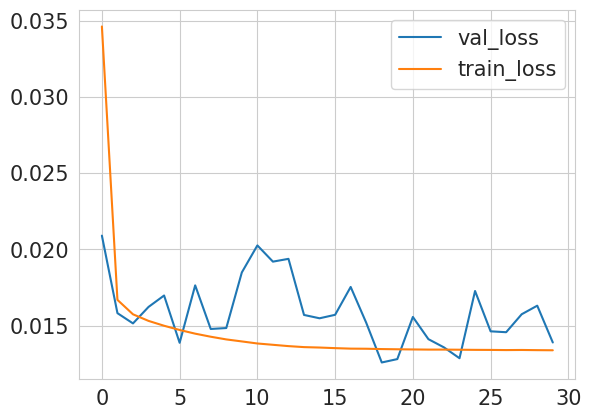

In [75]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [77]:
print(f'Best val_loss for lags=10: ', round(min(val_losses), 5))

Best val_loss for lags=10:  0.01258


### 3. Number of lags = <i><b>20</b></i>.

In [79]:
N_LAGS = 20

In [81]:
X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(InputLayer((N_LAGS, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=7)

Epoch 1/7
4553/4553 [==============================] - 79s 17ms/step - loss: 0.0264 - root_mean_squared_error: 0.1625 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1477
Epoch 2/7
4553/4553 [==============================] - 70s 15ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1305
Epoch 3/7
4553/4553 [==============================] - 61s 13ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1378
Epoch 4/7
4553/4553 [==============================] - 87s 19ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1499
Epoch 5/7
4553/4553 [==============================] - 72s 16ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 6/7
4553/4553 [==============================] - 82s 18ms/step - loss: 0.0134 - root_mean_squared_error: 0.1156 - val_l

In [82]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

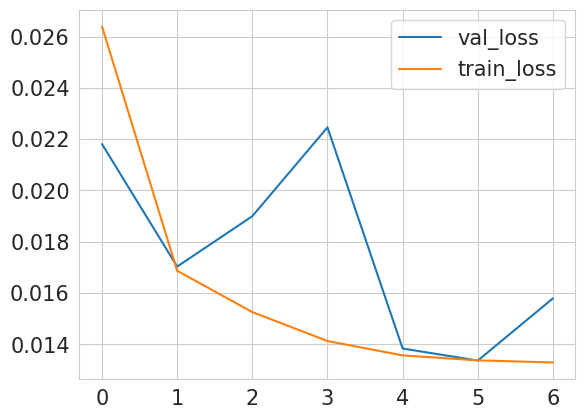

In [83]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [84]:
print(f'Best val_loss for lags=20: ', round(min(val_losses), 5))

Best val_loss for lags=20:  0.01336


## Find best learning rate

In [103]:
FILLING_NAN_METHOD = 'mean'

df_train_filled = fill_missing_values(df_train, method=FILLING_NAN_METHOD)
df_val_filled = fill_missing_values(df_val, method=FILLING_NAN_METHOD)

scaler = StandardScaler()
df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]

df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')

df_train_filled.drop(columns=['ds'], inplace=True)
df_val_filled.drop(columns=['ds'], inplace=True)

N_LAGS = 5

X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

### 1. learning rate = <i><b>1e-2</b></i>.

In [94]:
LEARNING_RATE = 1e-2

In [95]:
model = Sequential()
model.add(InputLayer((N_LAGS, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 33s 7ms/step - loss: 0.0187 - root_mean_squared_error: 0.1367 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1177
Epoch 2/20
4553/4553 [==============================] - 24s 5ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 3/20
4553/4553 [==============================] - 23s 5ms/step - loss: 0.0142 - root_mean_squared_error: 0.1190 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 4/20
4553/4553 [==============================] - 24s 5ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 5/20
4553/4553 [==============================] - 25s 6ms/step - loss: 0.0139 - root_mean_squared_error: 0.1181 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1300
Epoch 6/20
4553/4553 [==============================] - 23s 5ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_l

In [96]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

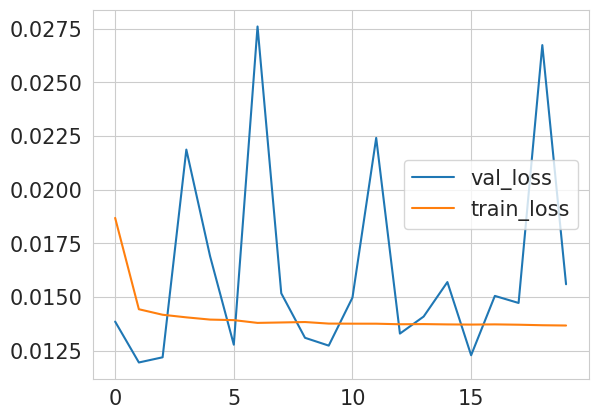

In [97]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [98]:
print(f'Best val_loss for lr=1e-2: ', round(min(val_losses), 5))

Best val_loss for lr=1e-2:  0.01194


### 2. learning rate = <i><b>1e-3</b></i>.

In [104]:
LEARNING_RATE = 1e-3

In [105]:
model = Sequential()
model.add(InputLayer((N_LAGS, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 27s 6ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 2/20
4553/4553 [==============================] - 25s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 3/20
4553/4553 [==============================] - 26s 6ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1290
Epoch 4/20
4553/4553 [==============================] - 25s 6ms/step - loss: 0.0151 - root_mean_squared_error: 0.1228 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 5/20
4553/4553 [==============================] - 27s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 6/20
4553/4553 [==============================] - 27s 6ms/step - loss: 0.0144 - root_mean_squared_error: 0.1199 - val_l

In [106]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

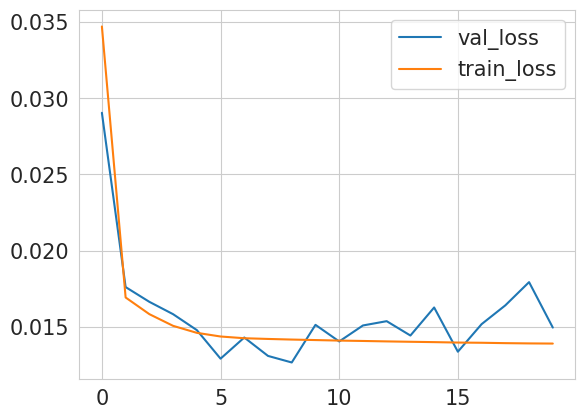

In [107]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [108]:
print(f'Best val_loss for lr=1e-3: ', round(min(val_losses), 5))

Best val_loss for lr=1e-3:  0.01267


### 3. learning rate = <i><b>1e-4</b></i>.

In [109]:
LEARNING_RATE = 1e-4

In [110]:
model = Sequential()
model.add(InputLayer((N_LAGS, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
4553/4553 [==============================] - 28s 6ms/step - loss: 0.1096 - root_mean_squared_error: 0.3311 - val_loss: 0.1592 - val_root_mean_squared_error: 0.3990
Epoch 2/20
4553/4553 [==============================] - 24s 5ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3099
Epoch 3/20
4553/4553 [==============================] - 25s 5ms/step - loss: 0.0187 - root_mean_squared_error: 0.1368 - val_loss: 0.0738 - val_root_mean_squared_error: 0.2716
Epoch 4/20
4553/4553 [==============================] - 26s 6ms/step - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0651 - val_root_mean_squared_error: 0.2552
Epoch 5/20
4553/4553 [==============================] - 25s 5ms/step - loss: 0.0182 - root_mean_squared_error: 0.1348 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2416
Epoch 6/20
4553/4553 [==============================] - 26s 6ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_l

In [111]:
train_losses = model_history.history['loss']
val_losses = model_history.history['val_loss']

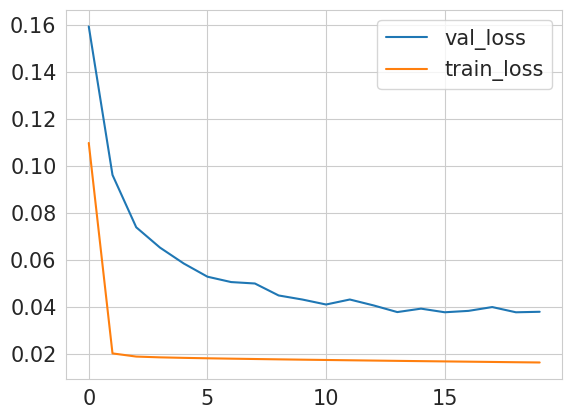

In [112]:
plt.plot(val_losses, label='val_loss')
plt.plot(train_losses, label='train_loss')
plt.legend()

In [113]:
print(f'Best val_loss for lr=1e-4: ', round(min(val_losses), 5))

Best val_loss for lr=1e-4:  0.03758


# Prediction on test data

In [ ]:
FILLING_NAN_METHOD = 'mean'

df_train_filled = fill_missing_values(df_train, method=FILLING_NAN_METHOD)
df_val_filled = fill_missing_values(df_val, method=FILLING_NAN_METHOD)
df_test_filled = fill_missing_values(df_test, method=FILLING_NAN_METHOD)

scaler = StandardScaler()
df_train_filled.y = scaler.fit_transform(np.array(df_train_filled.y).reshape(-1, 1)).T[0]
df_val_filled.y = scaler.transform(np.array(df_val_filled.y).reshape(-1, 1)).T[0]
df_test_filled.y = scaler.transform(np.array(df_test_filled.y).reshape(-1, 1)).T[0]

df_train_filled.index = pd.to_datetime(df_train_filled['ds'], format='%Y-%m-%d %H:%M:%S')
df_val_filled.index = pd.to_datetime(df_val_filled['ds'], format='%Y-%m-%d %H:%M:%S')
df_test_filled.index = pd.to_datetime(df_test_filled['ds'], format='%Y-%m-%d %H:%M:%S')

df_train_filled.drop(columns=['ds'], inplace=True)
df_val_filled.drop(columns=['ds'], inplace=True)
df_test_filled.drop(columns=['ds'], inplace=True)

In [ ]:
N_LAGS = 5
LEARNING_RATE =

X_train, y_train = df_to_X_y(df_train_filled, N_LAGS)
X_val, y_val = df_to_X_y(df_val_filled, N_LAGS)

model = Sequential()
model.add(InputLayer((N_LAGS, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

cp = ModelCheckpoint('best_model/', save_best_only=True, monitor='val_loss', mode='min')
model.compile(loss=MeanSquaredError(), optimizer=SGD(learning_rate=LEARNING_RATE, momentum=0.9), metrics=[RootMeanSquaredError()])
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[cp], epochs=10)

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('best_model/')

TypeError: Error when deserializing class 'MeanSquaredError' using config={'reduction': 'none', 'name': 'mean_squared_error'}.

Exception encountered: MeanSquaredError.__init__() got an unexpected keyword argument 'reduction'

In [ ]:
X_test, y_test = df_to_X_y(df_test_filled, N_LAGS)

test_predictions = loaded_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':list(test_predictions), 'Actuals':list(y_test)})
test_results

In [ ]:
print("test mse: ", mean_squared_error(test_results['Actuals'], test_results['Test Predictions']))
print(f"mape: {round(mean_absolute_percentage_error(test_results['Actuals'], test_results['Test Predictions']) * 100, 4)}")
print("test smape: ", calc_smape(test_results['Actuals'], test_results['Test Predictions']))

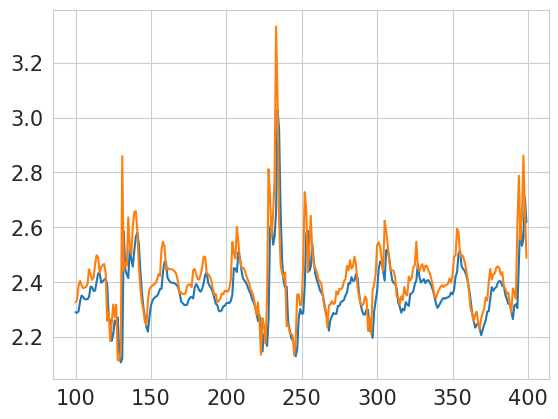

In [ ]:
s = slice(5000, 5200)
plt.plot(test_results['Test Predictions'][s], label='y_pred')
plt.plot(test_results['Actuals'][s], label='y_true')